In [2]:
from allensdk.brain_observatory.ecephys.dynamic_gating_ecephys_session import DynamicGatingEcephysSession

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os, glob

import matplotlib as mpl
import os
from ccf_utils import *
mpl.rcParams['pdf.fonttype'] = 42

## Make Trial raster for example experiment

In [3]:
session = DynamicGatingEcephysSession.from_nwb_path(r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\nwbs\1179670730\1179670730.nwb")

In [4]:
stimulus_presentations = session.stimulus_presentations
eye_tracking = session.eye_tracking
running_speed = session.running_speed
licks = session.licks

In [5]:
eye_tracking_noblinks = eye_tracking[~eye_tracking['likely_blink']]

In [6]:
units = session.get_units()
quality_filter = ((units['isi_violations'] < 0.5) & 
                 (units['amplitude_cutoff']< 0.1) & 
                 (units['presence_ratio'] > 0.95) & 
                 (units['quality'] == 'good') &
                 ([True]*len(units)))

good_units = units[quality_filter]

In [7]:
len(good_units)

987

In [8]:
channels = session.get_channels()
good_units = good_units.merge(channels, left_on='peak_channel_id', right_index=True)
good_units = good_units.merge(session.probes, left_on='probe_id', right_index=True)
good_units = good_units[good_units['structure_acronym']!='No Area']
good_units.value_counts('structure_acronym')

structure_acronym
SSp      129
VISp     100
POL       67
PL        67
SUB       62
ACAv      60
ACAd      41
LSc       34
CP        34
ILA       34
ACB       32
VISrl     30
TTd       26
RSPd      25
RSPv      24
RT        19
Eth       18
RPF       18
MOs       16
LSr       15
MB        14
STR       14
CA1       13
OP        12
CA3       11
DG        11
SGN       10
SF         9
ProS       8
TRS        7
PoT        6
TH         6
NPC        5
PPT        3
LGv        3
MRN        2
LP         1
VPL        1
dtype: int64

In [9]:
structure_tree = pd.read_csv(r"..\ccf_structure_tree_2017.csv")

In [10]:
#To group units by brain division (cortex, thalamus, midbrain etc)
unit_brain_divisions = good_units.apply(lambda row: get_brain_division_for_area(row['structure_acronym'], structure_tree), axis=1)
good_units['brain_division'] = unit_brain_divisions

In [11]:
good_units['brain_division'].value_counts()

Isocortex                526
Striatum                 138
Thalamus                 131
Hippocampal formation    105
Midbrain                  54
Olfactory areas           26
Pallidum                   7
Name: brain_division, dtype: int64

In [12]:
# Specify order in which to stack these brain divisions for the raster
brain_division_order = {
    'Isocortex': 1,
    'Hippocampal formation': 2,
    'Thalamus': 3,
    'Striatum': 4,
    'Midbrain': 5,
    'Olfactory areas': 6,
    'not in list': 7
}

good_units['brain_division_order'] = good_units.apply(lambda row: brain_division_order.get(row['brain_division'], 7), axis=1)

In [13]:
def plot_raster(ax, units, spike_times, alignment_time, time_before = 1, time_after = 1):
        
    for iu, (uid, unit) in enumerate(units.iterrows()):
        
        area = unit['structure_acronym']
        color = get_area_color(area, structure_tree)
        
        spikes = spike_times[uid]
        spikes = spikes[(spikes>alignment_time-time_before)&(spikes<alignment_time+time_after)]
        
        spikes = spikes - alignment_time
        
        ax.eventplot(spikes, lineoffsets=iu, color=color)
                

In [14]:
#Function to clean up CCF area designations for plotting
def strip_subregions_layers(areastr):
    
    if not isinstance(areastr, str):
        return areastr
    
    areastr = areastr.split('-')[0]
    #remove layer stuff
    areaname = structure_tree[structure_tree['acronym']==areastr]['name'].values
    if len(areaname)==0:
        return areastr
    else:
        areaname = areaname[0]
        
    if 'layer' in areaname:
        layer = areaname.split('layer')[-1].split(' ')[-1]
        areastr = areastr.replace(layer, '')
        
    #hack for ACA and MOp
    if 'ACAd' in areastr:
        areastr = 'ACAd'
        
    if 'ACAv' in areastr:
        areastr = 'ACAv'

    if 'MOp' in areastr:
        areastr = 'MOp'
    
    if 'SC' in areastr:
        parents = list_parents(areastr, structure_tree)
        if 'Superior colliculus sensory related' in parents:
            areastr = 'SCs'
        elif 'Superior colliculus motor related' in parents:
            areastr = 'SCm'

    return areastr    
    

In [15]:
structure_acronym_no_layers = good_units.apply(lambda row: strip_subregions_layers(row['structure_acronym']), axis=1)
good_units['structure_acronym_no_layers'] = structure_acronym_no_layers

In [16]:
stimulus_presentations = stimulus_presentations.merge(session.trials, left_on='trials_id', right_index=True, suffixes=(None, '_trials'))

In [17]:
# Align the raster to the first reward delivery that cues the end of the no reward period
first_reengaged_rewards = stimulus_presentations[(stimulus_presentations['is_change'])&
                                               (stimulus_presentations['auto_rewarded'])&
                                               (stimulus_presentations['trials_id']>10)]

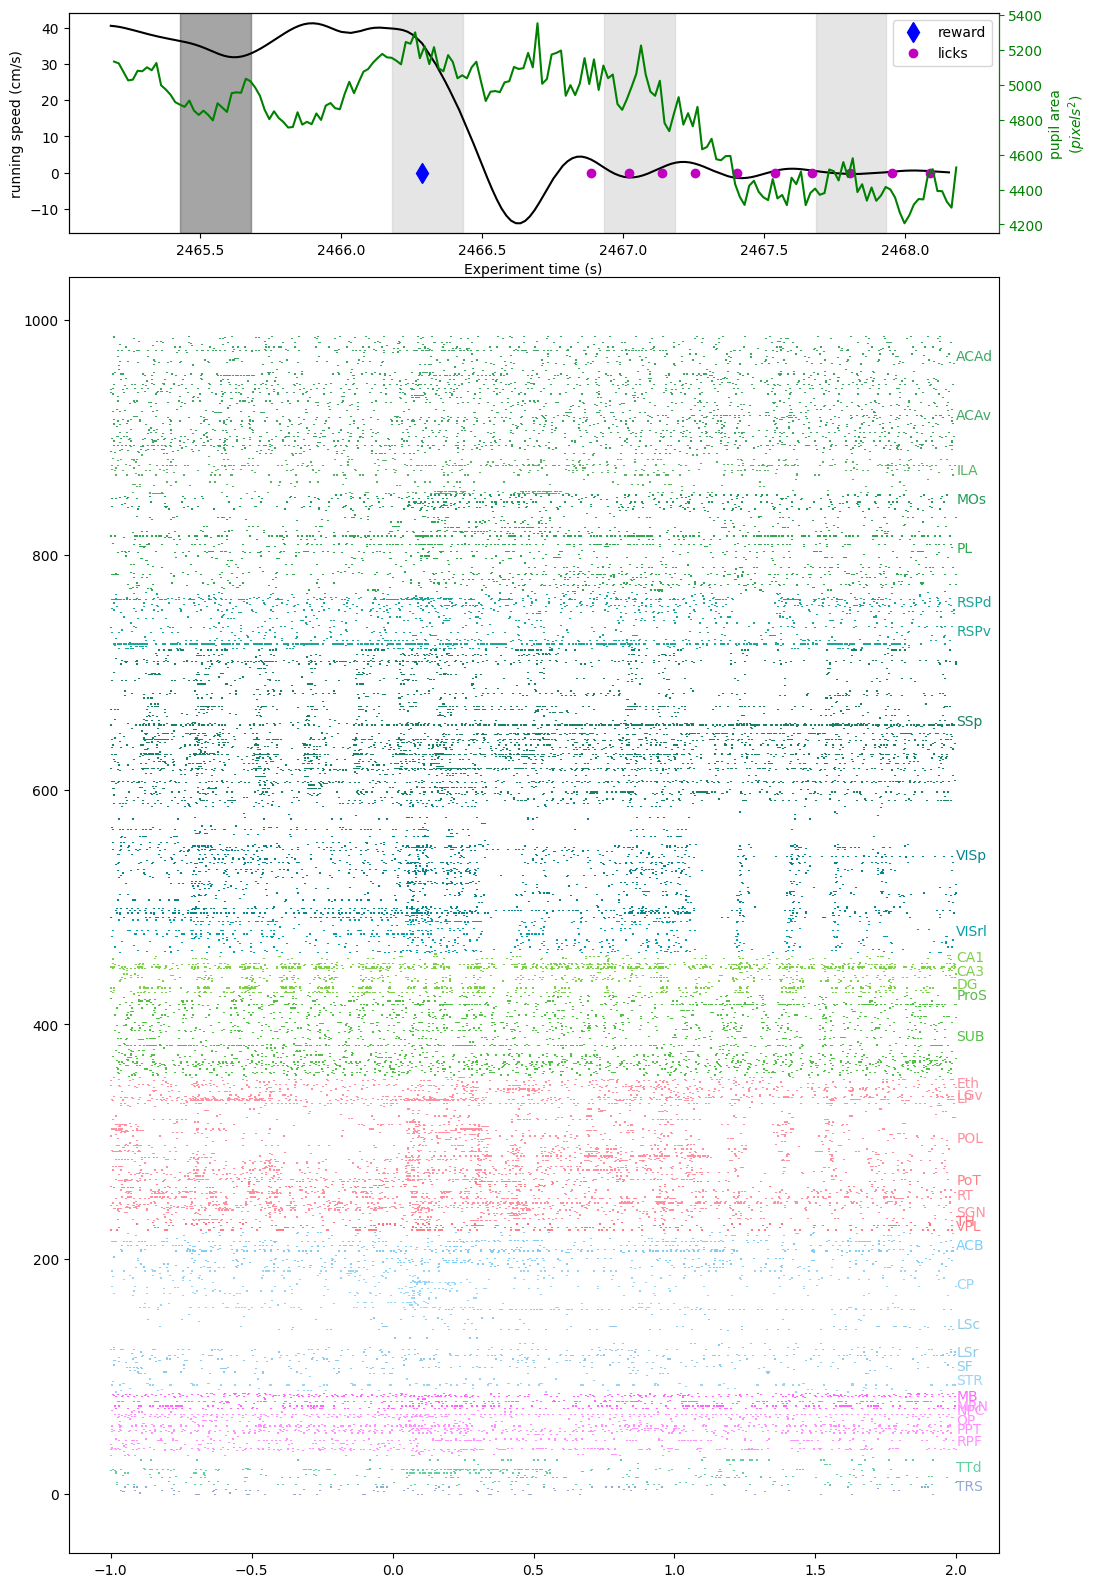

In [18]:
align_time = first_reengaged_rewards.iloc[2]['start_time']

time_before = 1
time_after = 2

#Get running data aligned to this reward
trial_running = running_speed.query('timestamps >= {} and timestamps <= {} '.
                                    format(align_time-time_before, align_time+time_after))

#Get pupil data aligned to this reward
trial_pupil_area = eye_tracking_noblinks.query('timestamps >= {} and timestamps <= {} '.
                                    format(align_time-time_before, align_time+time_after))

#Get stimulus presentations around this reward
behavior_presentations = stimulus_presentations[stimulus_presentations['active']]
behavior_presentations = behavior_presentations[(behavior_presentations['omitted']==False)]
trial_stimuli = behavior_presentations.query('end_time >= {} and start_time <= {}'.
                                             format(align_time-time_before, align_time+time_after))

#Get licking aligned to this reward
trial_licking = licks.query('timestamps >= {} and timestamps <= {} '.
                                    format(align_time-time_before, align_time+time_after))

reward_time = session.rewards.query('timestamps >= {} and timestamps <= {} '.
                                    format(align_time-time_before, align_time+time_after))['timestamps'].values[0]



fig = plt.figure(figsize=(12, 20))
spec = fig.add_gridspec(6, 1)

ax_spikes = fig.add_subplot(spec[1:])
axr = fig.add_subplot(spec[0])

plot_raster(ax_spikes, good_units.sort_values(by=['brain_division_order', 'structure_acronym', 'dorsal_ventral_ccf_coordinate'], ascending=False), 
            session.spike_times, align_time, time_before=time_before, time_after= time_after)

#Plot running, pupil area and licks
axr.plot(trial_running['timestamps'], trial_running['speed'], 'k')
axp = axr.twinx()
axp.plot(trial_pupil_area['timestamps'], trial_pupil_area['pupil_area'], 'g')
rew_handle, = axr.plot(reward_time, 0, 'db', markersize=10)
lick_handle, = axr.plot(trial_licking['timestamps'], np.zeros(len(trial_licking['timestamps'])), 'mo')
axr.legend([rew_handle, lick_handle], ['reward', 'licks'])

axr.set_ylabel('running speed (cm/s)')
axp.set_ylabel('pupil area\n$(pixels^2)$')
axr.set_xlabel('Experiment time (s)')

axp.yaxis.label.set_color('g')
axp.spines['right'].set_color('g')
axp.tick_params(axis='y', colors='g')

#Plot the image flashes as grey bars. 
colors = ['0.3', '0.8']
stimulus_colors = {stim: c for stim,c in zip(trial_stimuli['image_name'].unique(), colors)}
for idx, stimulus in trial_stimuli.iterrows():
    axr.axvspan(stimulus['start_time'], stimulus['end_time'], color=stimulus_colors[stimulus['image_name']], alpha=0.5)
    
    
area_labels = good_units.sort_values(by=['brain_division_order', 'structure_acronym', 'dorsal_ventral_ccf_coordinate'], ascending=False)['structure_acronym_no_layers'].values
for label in np.unique(area_labels):
    indices = np.where(area_labels==label)[0]
    ax_spikes.text(time_after, np.median(indices), label, color=get_area_color(label, structure_tree))

## Panel showing waveform stability over time

In [43]:
waveform = session.mean_waveforms[37371]
waveform.max() - waveform.min()

555.0222600000001

In [48]:
# Get probe for example unit
good_units.loc[37371]['name']

'probeC'

In [47]:
# In order to plot the waveform over time, we need to access the raw data for this experiment. This file can be provided on request.
raw_data = np.memmap(r"\\allen\programs\mindscope\workgroups\np-exp\1179670730_612090_20220524\1179670730_612090_20220524_probeC_sorted\continuous\Neuropix-PXI-100.0\continuous.dat",
                    dtype='int16', mode='r')
raw_data = np.reshape(raw_data, [int(raw_data.size/384), -1])


FileNotFoundError: [Errno 2] No such file or directory: '\\\\allen\\programs\\mindscope\\workgroups\\np-exp\\1179670730_612090_20220524\\1179670730_612090_20220524_probeC_sorted\\continuous\\Neuropix-PXI-100.0\\continuous.dat'

In [583]:
#Look at waveform stability over time

unitid = 37371

unit_times = session.spike_times[unitid]
unit_peak_chan = good_units.loc[unitid]['probe_channel_number']

unit_data = raw_data[:, unit_peak_chan - 20: unit_peak_chan + 20]

offset = 4.82447193064198
samplerate = 30000.21724868578

maxtime = stimulus_presentations['end_time'].max()
epoch_number = 5
epoch_starts = np.arange(0, maxtime, int(np.round(maxtime/epoch_number)))
epoch_ends = np.append(epoch_starts[1:], maxtime)

epoch_waveforms = []
for es, ee in zip(epoch_starts, epoch_ends):
    times = unit_times[(unit_times>es)&(unit_times<=ee)]
    waveforms = []
    for spike in times[:100]:
        sample = int((spike-offset)*samplerate)

        waveform = unit_data[sample-50:sample+50]
        waveforms.append(waveform)

    mean_waveform = np.mean(waveforms,axis=0)*0.195
    epoch_waveforms.append(mean_waveform)

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_23584\2821270742.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[ie].pcolor(np.arange(-50, 50)/30., np.arange(-20, 20, 2),
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_23584\2821270742.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[ie].pcolor(np.arange(-50, 50)/30., np.arange(-20, 20, 2),
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_23584\2821270742.py:8: MatplotlibDeprecationWarning: shading='fl

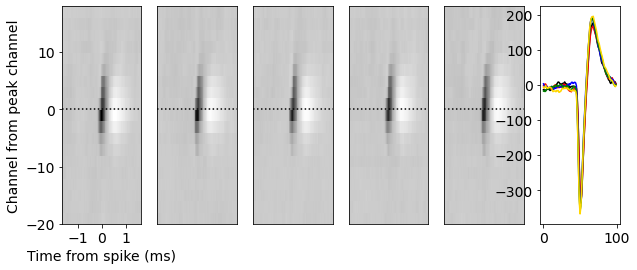

In [588]:
grand_min = np.min(epoch_waveforms)
grand_max = np.max(epoch_waveforms)
fig, ax = plt.subplots(1, epoch_number+1)
fig.set_size_inches(10, 4)
colors = ['k', 'r', 'b', 'g', 'gold']
for ie, epoch in enumerate(epoch_waveforms):
    #ax[ie].imshow(epoch.T)
    ax[ie].pcolor(np.arange(-50, 50)/30., np.arange(-20, 20, 2), 
                  epoch[:, ::2].T, cmap='Greys_r', vmin = grand_min, vmax=grand_max)
    ax[ie].axhline(0, ls='dotted', c='k')
    #ax[ie].set_title(np.max(epoch) - np.min(epoch))
    if ie==0:
        ax[ie].set_xlabel('Time from spike (ms)')
        ax[ie].set_ylabel('Channel from peak channel')
    else:
        ax[ie].xaxis.set_visible(False)
        ax[ie].yaxis.set_visible(False)

    ax[5].plot(epoch[:, 20], colors[ie])
    
fig.savefig(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures', 'waveform_stability_example_332984_1179670730.pdf'))

## Panel comparing quality metrics for DG and VBN

In [4]:
# List of sessions that pass ephys QC
PASSING_EPHYS_SESSION_IDS = [1182427414, 1182628226, 1182871514, 1183071525, 1177900858,
       1178173272, 1178460518, 1178693650, 1174553025, 1174790219,
       1175067685, 1175253205, 1176580734, 1176791184, 1176989662,
       1189336645, 1189820015, 1190094328, 1190290940, 1179670730,
       1179911454, 1180107381, 1180266229, 1181096406, 1181324124,
       1181731440, 1187475832, 1187668018, 1188138256, 1190892228,
       1191131853, 1191375883, 1191631184, 1197514969, 1197725774,
       1197967151, 1198130743, 1194411467, 1194850630, 1195036753,
       1198796984, 1198995158, 1199249150, 1199448636, 1208053773,
       1208664393, 1209073822, 1200260055, 1200471383, 1200659846,
       1202438738, 1202644967, 1203574877, 1204636084, 1210343162,
       1210608527, 1210863396, 1214217748, 1214409109, 1214566710,
       1214740195, 1218577463, 1218795542, 1219127153, 1219401111,
       1226010097, 1226251663, 1226528572, 1227622013, 1227855488,
       1230732154, 1230962048, 1231219674, 1229429400, 1229654875,
       1229887685, 1230064747, 1234028213, 1234203203, 1234410451,
       1232430325, 1232725697, 1232954220, 1233182785, 1243523806,
       1243799530, 1244070169]

In [5]:
dynamic_gating_sessions = pd.read_csv(r"..\..\metadata_tables\dynamic_gating_session_metadata.csv")

dynamic_gating_probes = pd.read_csv(r"..\..\metadata_tables\probes_table.csv")


In [6]:
dg_sessions_passing = dynamic_gating_sessions[dynamic_gating_sessions['ecephys_session_id'].isin(PASSING_EPHYS_SESSION_IDS)]
mouse_info = dg_sessions_passing.groupby('mouse_id').head(1)
print(mouse_info.value_counts('genotype'))
print(mouse_info.value_counts('sex'))


genotype
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    14
wt/wt                                             6
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt     4
Ai32(RCL-ChR2(H134R)_EYFP)/wt                     1
dtype: int64
sex
M    18
F     7
dtype: int64


In [7]:
dg_metrics = pd.read_csv(r"..\..\metadata_tables\units_table.csv")

In [8]:
dg_metrics = dg_metrics[dg_metrics['session'].isin(PASSING_EPHYS_SESSION_IDS)]
dg_probes = pd.read_csv(r"..\..\metadata_tables\probes_table.csv")
dg_metrics = dg_metrics.merge(dg_probes, left_on='probe_id', right_on='id', suffixes=['', '_probes'])

In [9]:
dg_metrics = dg_metrics.merge(dynamic_gating_sessions, left_on='session_id', right_on='ecephys_session_id')

In [10]:
probe_insertions_per_mouse = dg_metrics.pivot_table(index='mouse_id', values='probe_id', aggfunc=lambda x: len(np.unique(x)))

(array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 3.,
        3., 4., 2., 0., 0., 3., 6.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <BarContainer object of 24 artists>)

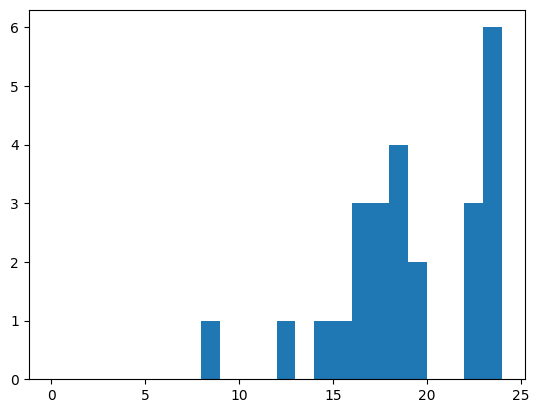

In [11]:
fig, ax = plt.subplots()
ax.hist(probe_insertions_per_mouse, bins=np.arange(25))

In [12]:
number_of_insertions = dg_metrics['probe_id'].unique().size
print(f'number_of_insertions: {number_of_insertions}')
number_of_experiments = dg_metrics['session_id'].unique().size
print(f'number_of_experiments: {number_of_experiments}')

number_of_mice = dynamic_gating_sessions[dynamic_gating_sessions['ecephys_session_id'].isin(PASSING_EPHYS_SESSION_IDS)]['mouse_id'].unique().size
print(f'number_of_mice: {number_of_mice}')


number_of_insertions: 467
number_of_experiments: 87
number_of_mice: 25


In [13]:
insertion_success_rate = number_of_insertions/number_of_experiments

In [14]:
dg_metrics_inarea = dg_metrics[~dg_metrics['structure_acronym'].isin(['No Area', 'out of brain', 'Track not annotated'])]

In [15]:
num_insertions_per_session = dg_metrics_inarea.pivot_table(index='session_id', values='probe_id', aggfunc=lambda x: np.unique(x).size)

In [16]:
six_probe_experiments = num_insertions_per_session[num_insertions_per_session==6]
six_probe_experiments = six_probe_experiments.dropna().index.values

dg_metrics_inarea_six_probes = dg_metrics_inarea[dg_metrics_inarea['session_id'].isin(six_probe_experiments)]

In [17]:
df_to_use = dg_metrics_inarea_six_probes

number_of_areas_per_experiment = df_to_use.pivot_table(index='session_id', values='structure_acronym', 
                            aggfunc=lambda x: len(np.unique(x)))

print(f'areas recorded per experiment: {number_of_areas_per_experiment.mean()} +/- {number_of_areas_per_experiment.std()}')

quality_filter = ((df_to_use['isi_violations'] < 0.5) & 
                 (df_to_use['amplitude_cutoff']< 0.1) & 
                 (df_to_use['presence_ratio'] > 0.95) & 
                 (df_to_use['quality'] == 'good'))
quality_filter = (df_to_use['quality']=='good')

number_of_units_per_experiment = df_to_use[quality_filter].pivot_table(index='session_id', values='structure_acronym', 
                            aggfunc='count')
print(f'units recorded per experiment: {number_of_units_per_experiment.mean()} +/- {number_of_units_per_experiment.std()}')


areas recorded per experiment: structure_acronym    28.113636
dtype: float64 +/- structure_acronym    5.122753
dtype: float64
units recorded per experiment: structure_acronym    1820.977273
dtype: float64 +/- structure_acronym    341.870266
dtype: float64


In [18]:
vbn_metrics = pd.read_csv(r"..\..\metadata_tables\VBN_units_table.csv")
vbn_sessions = pd.read_csv(r"..\..\metadata_tables\VBN_sessions.csv")

vbn_metrics = vbn_metrics.merge(vbn_sessions, on='ecephys_session_id')

In [19]:
#Only consider non 'noise' units
dg_good = dg_metrics[dg_metrics['quality']=='good']
vbn_good = vbn_metrics[(vbn_metrics['quality']=='good')]

In [20]:
def filter_by_quality(table):
    quality_filter = ((table['isi_violations'] < 0.5) & 
                 (table['amplitude_cutoff']< 0.1) & 
                 (table['presence_ratio'] > 0.95) & 
                 (table['quality'] == 'good'))
    return table[quality_filter]

percentage_dg_passing_quality_metrics = len(filter_by_quality(dg_good))/len(dg_good)
percentage_vbn_passing_quality_metrics = len(filter_by_quality(vbn_good))/len(vbn_good)

print(f'dg pass % {100*percentage_dg_passing_quality_metrics} \n vbn pass % {100*percentage_vbn_passing_quality_metrics}')

dg pass % 41.143588174764304 
 vbn pass % 40.69006816005981


In [21]:
from scipy.stats import mannwhitneyu
import scipy.stats

In [22]:
print(f'num dg units: {len(dg_good)}')
print(f'num vbn units: {len(vbn_good)}')


num dg units: 143828
num vbn units: 262177


In [23]:
def bootstrap_median_CI(values, num_iterations=1000, CI_span=95):
    sample_medians = []
    for iteration in range(num_iterations):
        sample_values = np.random.choice(values, len(values))
        sample_medians.append(np.median(sample_values))
    
    one_side = (100-CI_span)/2
    CI = [np.percentile(sample_medians, p) for p in [one_side, 100-one_side]]

    return CI

presence_ratio DG nan: 0
presence_ratio VBN nan: 0
dg presence_ratio: median 0.99 CI [0.99, 0.99]
vbn presence_ratio: median 0.99 CI [0.99, 0.99]
presence_ratio pval: 1.4431554452180584e-156
amplitude_cutoff DG nan: 0
amplitude_cutoff VBN nan: 0
dg amplitude_cutoff: median 0.043882893000000006 CI [0.0434046958125, 0.0447627696]
vbn amplitude_cutoff: median 0.049473261 CI [0.048641355324999996, 0.04981922435]
amplitude_cutoff pval: 6.0026765967954035e-18
isi_violations DG nan: 0
isi_violations VBN nan: 0
dg isi_violations: median 0.06986956999999999 CI [0.06902877661250001, 0.070674145125]
vbn isi_violations: median 0.088750201 CI [0.087449998275, 0.089224749925]
isi_violations pval: 1.6547896141996843e-230
snr DG nan: 0
snr VBN nan: 0
dg snr: median 2.472276017 CI [2.4673722306, 2.47531846825]
vbn snr: median 2.496920586 CI [2.491558502925, 2.498722795475]
snr pval: 1.3677441679789928e-05
isolation_distance DG nan: 0
isolation_distance VBN nan: 0
dg isolation_distance: median 56.143586

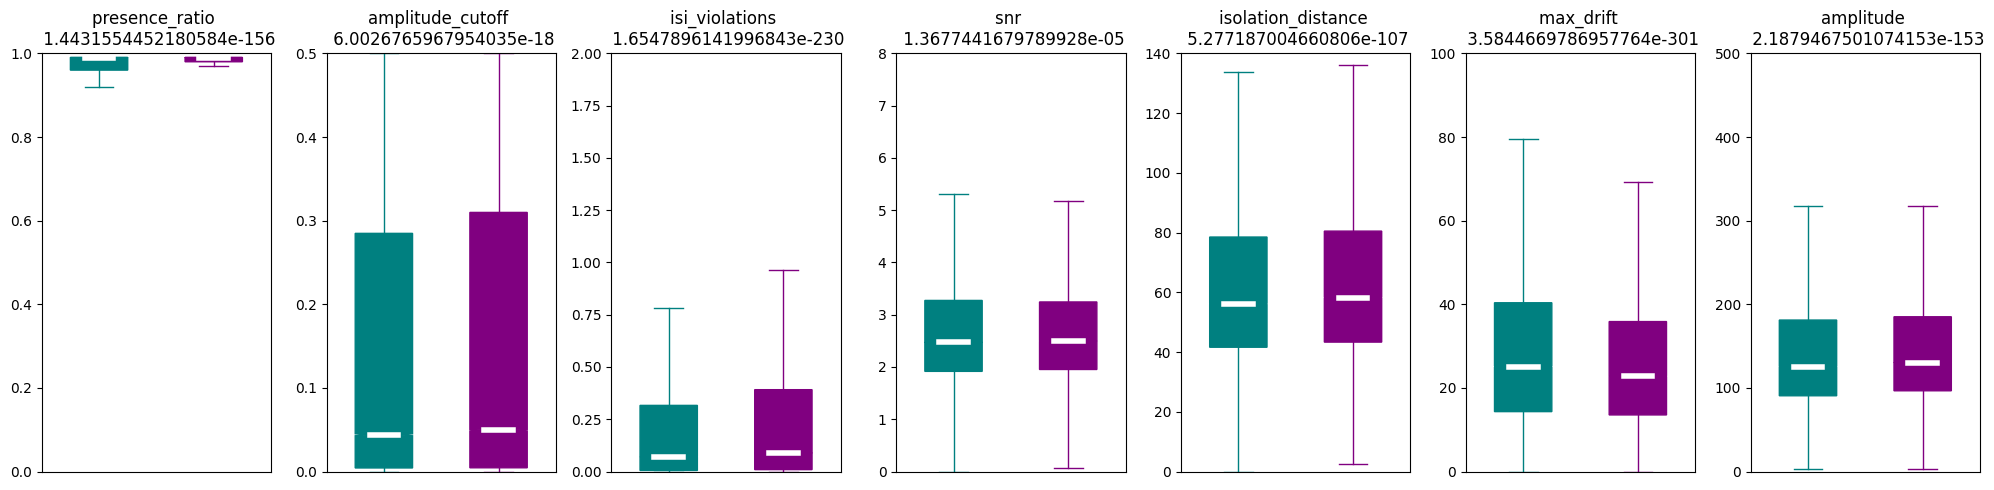

In [24]:
metrics = ['presence_ratio', 
           'amplitude_cutoff', 
           'isi_violations', 
           'snr', 
           'isolation_distance',
           'max_drift', 
           'amplitude']

ranges = [
          [0,1],
          [0,0.5],
          [0,2],
          [0,8],
          [0,140],
          [0, 100],
          [0, 500]]



fig, ax = plt.subplots(1, len(metrics))
fig.set_size_inches([20, 5])
dg_color = 'teal'
vbn_color = 'purple'

for idx, metric in enumerate(metrics):
    
    dg_data = dg_good[metric].values
    print(f'{metric} DG nan: {np.sum(np.isnan(dg_data))}')

    dg_data = dg_data[np.invert(np.isnan(dg_data))]

    
    vbn_data = vbn_good[metric].values
    print(f'{metric} VBN nan: {np.sum(np.isnan(dg_data))}')
    
    vbn_data = vbn_data[np.invert(np.isnan(vbn_data))]

    
    for idata, (data, color) in enumerate(zip([dg_data, vbn_data], [dg_color, vbn_color])):
        ax[idx].boxplot(data, positions=[idata], notch=True, patch_artist=True,
                boxprops=dict(facecolor=color, color=color),
                capprops=dict(color=color),
                whiskerprops=dict(color=color),
                flierprops=dict(color=color, markeredgecolor=color),
                medianprops=dict(color='w',lw=4),
                showfliers=False,
                widths = 0.5
                )

    for label, data in zip(['dg', 'vbn'], [dg_data, vbn_data]):
        CI = bootstrap_median_CI(data, num_iterations=10)
        print(f'{label} {metric}: median {np.median(data)} CI {CI}') #formula for approximating standard error of median
    
    pval = mannwhitneyu(dg_data, vbn_data, nan_policy='omit')[1]
    print(f'{metric} pval: {pval}')
    ax[idx].set_ylim(ranges[idx])
    
    ax[idx].set_title(f'{metric} \n {pval}')
    ax[idx].xaxis.set_visible(False)
plt.tight_layout()

#fig.savefig(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures', 'dg_vbn_metrics_comparison.pdf'))

In [26]:
vbn_unit_counts = vbn_good.pivot_table(index=['session_number', 'ecephys_session_id', 'ecephys_probe_id'], values=['amplitude'], aggfunc=len)
vbn_day_counts = [vbn_unit_counts.loc[sess_no]['amplitude'].values for sess_no in [1,2]]

In [28]:
unit_counts = dg_good.dropna(subset='session_type').pivot_table(index=['mouse_id', 'name', 'session_type'], values=['amplitude'], aggfunc=len)
unit_means = unit_counts.reset_index().groupby('session_type').mean()
unit_sems = unit_counts.reset_index().groupby('session_type').sem()

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_341784\4103718592.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  unit_means = unit_counts.reset_index().groupby('session_type').mean()
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_341784\4103718592.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  unit_sems = unit_counts.reset_index().groupby('session_type').sem()


In [29]:
day_counts = [unit_counts.loc[pd.IndexSlice[:, :, stim]]['amplitude'].values for stim in ['EPHYS_1', 'EPHYS_2', 'EPHYS_3', 'EPHYS_4']]


In [30]:
from statsmodels.stats.multitest import multipletests

In [31]:
pval = scipy.stats.kruskal(*(vbn_day_counts+day_counts), nan_policy='omit')
print(f'VBN pval for unit counts over days: {pval}')

pvals = []
for ivbn, vbnday in enumerate(vbn_day_counts):
    for idg, dgday in enumerate(day_counts):
        pval = scipy.stats.kruskal(vbnday, dgday, nan_policy='omit')[1]
        pvals.append(pval)

corrected_pvals = multipletests(pvals, method='fdr_bh')
count = 0
for ivbn, vbnday in enumerate(vbn_day_counts):
    for idg, dgday in enumerate(day_counts):
        pval = scipy.stats.kruskal(vbnday, dgday, nan_policy='omit')
        print(f'VBN day {ivbn} vs DG day {idg} pval for unit counts over days: {corrected_pvals[1][count]} sig: {corrected_pvals[0][count]}')
        count += 1

print ('DG')

pvals = []
for idg1, dgday1 in enumerate(day_counts):
    for idg, dgday in enumerate(day_counts):
        pval = scipy.stats.kruskal(dgday1, dgday, nan_policy='omit')[1]
        pvals.append(pval)

corrected_pvals = multipletests(pvals, method='fdr_bh')
count = 0
for idg1, dgday1 in enumerate(day_counts):
    for idg, dgday in enumerate(day_counts):
        print(f'DG day {idg1} vs DG day {idg} pval for unit counts over days: {corrected_pvals[1][count]} sig: {corrected_pvals[0][count]}')
        count += 1

VBN pval for unit counts over days: KruskalResult(statistic=109.2264015827727, pvalue=5.969957541916541e-22)
VBN day 0 vs DG day 0 pval for unit counts over days: 0.7836807837603376 sig: False
VBN day 0 vs DG day 1 pval for unit counts over days: 0.23904809706916794 sig: False
VBN day 0 vs DG day 2 pval for unit counts over days: 0.03180530230083644 sig: True
VBN day 0 vs DG day 3 pval for unit counts over days: 0.11138836427056721 sig: False
VBN day 1 vs DG day 0 pval for unit counts over days: 8.734011354203367e-08 sig: True
VBN day 1 vs DG day 1 pval for unit counts over days: 7.575076326681654e-06 sig: True
VBN day 1 vs DG day 2 pval for unit counts over days: 5.7394585365528666e-05 sig: True
VBN day 1 vs DG day 3 pval for unit counts over days: 0.0014218085620447659 sig: True
DG
DG day 0 vs DG day 0 pval for unit counts over days: 1.0 sig: False
DG day 0 vs DG day 1 pval for unit counts over days: 0.9356870629543095 sig: False
DG day 0 vs DG day 2 pval for unit counts over days: 0

In [32]:
pval = scipy.stats.kruskal(*day_counts, nan_policy='omit')
print(f'DG pval for unit counts over days: {pval}')

DG pval for unit counts over days: KruskalResult(statistic=2.4899205554660426, pvalue=0.47711541905510646)


stim: 0 num sessions: 129 median314.0
stim: 1 num sessions: 126 median305.5
stim: 2 num sessions: 121 median295.0
stim: 3 num sessions: 91 median303.0
stim: 0 num sessions: 459 median321.0
stim: 1 num sessions: 446 median261.0


(0.0, 460.0)

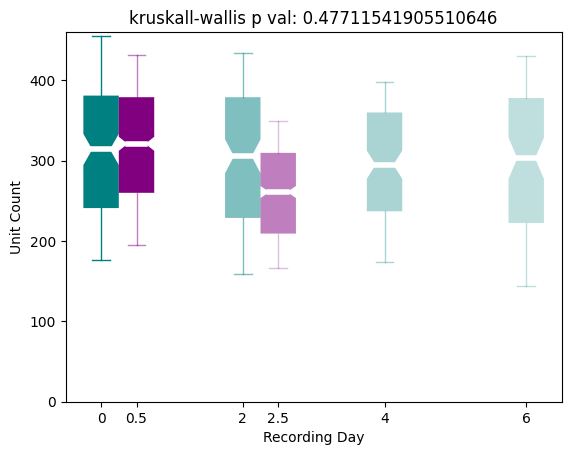

In [33]:
fig, ax = plt.subplots()
color = 'teal'
for istim, counts in enumerate(day_counts):
    #counts = unit_counts.loc[stim]['amplitude'].values
    ax.boxplot(counts, positions=[2*istim], notch=True, patch_artist=True, whis=(10,90),
                boxprops=dict(facecolor=color, linewidth=0, color=color, alpha=1/(istim+1)),
                capprops=dict(color=color, alpha=1/(istim+1)),
                whiskerprops=dict(color=color, alpha=1/(istim+1)),
                medianprops=dict(color='w',lw=4),
                showfliers=False,
                widths = 0.5
                )
    print(f'stim: {istim} num sessions: {len(counts)} median{np.median(counts)}')

color = 'purple'
for istim, counts in enumerate(vbn_day_counts):
    #counts = unit_counts.loc[stim]['amplitude'].values
    ax.boxplot(counts, positions=[2*istim+0.5], notch=True, patch_artist=True, whis=(10,90),
                boxprops=dict(facecolor=color, linewidth=0, color=color, alpha=1/(istim+1)),
                capprops=dict(color=color, alpha=0.5/(istim+1)),
                whiskerprops=dict(color=color, alpha=0.5/(istim+1)),
                medianprops=dict(color='w',lw=4),
                showfliers=False,
                widths = 0.5
                )
    print(f'stim: {istim} num sessions: {len(counts)} median{np.median(counts)}')


ax.set_ylabel('Unit Count')
ax.set_xlabel('Recording Day')
ax.set_title(f'kruskall-wallis p val: {pval[1]}')
ax.set_ylim([0, 460])
# fig.savefig(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures', 
#                          'unit_yield_by_day_corrected_for_phantom_insertions.pdf'))

In [34]:
firing_rate_by_stim = dg_good.pivot_table(index=['session_type', 'mouse_id', 'session'], values=['firing_rate'], aggfunc=('median', 'sem', 'count'))
firing_rate_by_stim = firing_rate_by_stim['firing_rate', 'median'].groupby('session_type').agg(list)

In [35]:
pval = scipy.stats.kruskal(*firing_rate_by_stim, nan_policy='omit')
print(pval)

KruskalResult(statistic=4.017936882109893, pvalue=0.25953377336575006)


stim: EPHYS_1 num sessions: 23
stim: EPHYS_2 num sessions: 24
stim: EPHYS_3 num sessions: 22
stim: EPHYS_4 num sessions: 18


Text(0.5, 1.0, 'kruskal p: 0.25953377336575006')

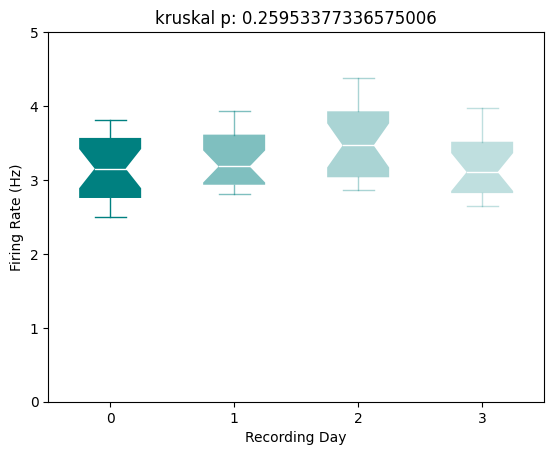

In [36]:
fig, ax = plt.subplots()
color = 'teal'
for istim, stim in enumerate(['EPHYS_1', 'EPHYS_2', 'EPHYS_3', 'EPHYS_4']):
    #firing_rates = dg_good[dg_good['session_type']==stim]['firing_rate'].values
    firing_rates = firing_rate_by_stim[stim]
    ax.boxplot(firing_rates, positions=[istim], notch=True, patch_artist=True, whis=(10,90),
                boxprops=dict(facecolor=color, linewidth=0, color=color, alpha=1/(istim+1)),
                capprops=dict(color=color, alpha=1/(istim+1)),
                whiskerprops=dict(color=color, alpha=1/(istim+1)),
                medianprops=dict(color='w',lw=1),
                showfliers=False,
                widths = 0.5
                )
    print(f'stim: {stim} num sessions: {len(firing_rates)}')
    #ax.violinplot(firing_rates, positions=[istim])
ax.set_ylabel('Firing Rate (Hz)')
ax.set_xlabel('Recording Day')
ax.set_ylim([0, 5])
ax.set_title(f'kruskal p: {pval[1]}')
# fig.savefig(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures', 
#                          'firing_rates_by_day.pdf'))

## RF stats across days

In [37]:
v1_units = dg_good[(dg_good['isi_label']=='VISp')]
v1_units['is_sig_rf'] = v1_units['p_value_rf'].values < 0.05
v1_units = filter_by_quality(v1_units)

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_341784\3036070708.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v1_units['is_sig_rf'] = v1_units['p_value_rf'].values < 0.05


In [38]:
fraction_v1_insertions_with_rfs_by_stim = v1_units.pivot_table(index=['session_type', 'mouse_id', 'session'], values=['is_sig_rf'], aggfunc=('mean', 'sem', 'count'))

In [39]:
fractionrfs = [fraction_v1_insertions_with_rfs_by_stim.loc[stim]['is_sig_rf', 'mean'].values for stim in ['EPHYS_1', 'EPHYS_2', 'EPHYS_3', 'EPHYS_4']]
pval = scipy.stats.kruskal(*fractionrfs, nan_policy='omit')
print(pval)

KruskalResult(statistic=3.0371183115038374, pvalue=0.3859375932331582)


stim EPHYS_1 num sessions 12
stim EPHYS_2 num sessions 11
stim EPHYS_3 num sessions 12
stim EPHYS_4 num sessions 11


(0.0, 1.0)

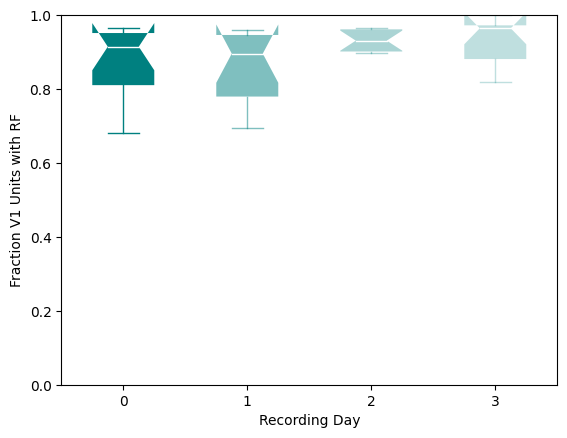

In [40]:
fig, ax = plt.subplots()
for istim, stim in enumerate(['EPHYS_1', 'EPHYS_2', 'EPHYS_3', 'EPHYS_4']):
    fractionrfs = fraction_v1_insertions_with_rfs_by_stim.loc[stim]['is_sig_rf', 'mean'].values
    ax.boxplot(fractionrfs, positions=[istim], notch=True, patch_artist=True, whis=(10,90),
                boxprops=dict(facecolor=color, linewidth=0, color=color, alpha=1/(istim+1)),
                capprops=dict(color=color, alpha=1/(istim+1)),
                whiskerprops=dict(color=color, alpha=1/(istim+1)),
                medianprops=dict(color='w',lw=1),
                showfliers=False,
                widths = 0.5
                )
    print(f'stim {stim} num sessions {len(fractionrfs)}')
ax.set_ylabel('Fraction V1 Units with RF')
ax.set_xlabel('Recording Day')
ax.set_ylim([0, 1])
# fig.savefig(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures', 
#                          'v1_fraction_rfs_by_day.pdf'))

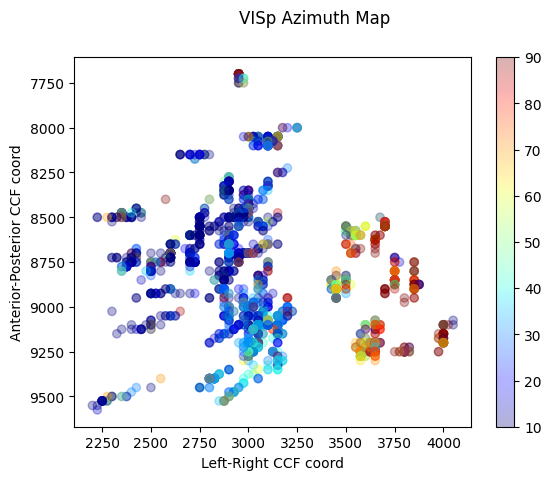

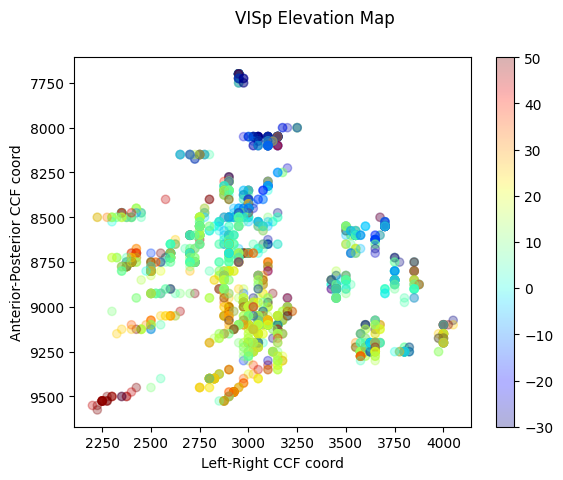

In [41]:
v1_sig_rf = v1_units[v1_units['is_sig_rf']]

for retinotopicaxis, axisname in zip(['Azimuth', 'Elevation'], ['azimuth_rf', 'elevation_rf']):
        fig, ax = plt.subplots()
        fig.suptitle(f'VISp {retinotopicaxis} Map')
        c = ax.scatter(v1_sig_rf['left_right_ccf_coordinate'], 
                v1_sig_rf['anterior_posterior_ccf_coordinate'],
                c=v1_sig_rf[axisname], cmap='jet', alpha=0.3)
        ax.invert_yaxis()
        ax.set_xlabel('Left-Right CCF coord')
        ax.set_ylabel('Anterior-Posterior CCF coord')
        plt.colorbar(c)

## Plot responses across days to one of the images (precomputed on cluster)

In [42]:
all_good_units = filter_by_quality(dg_good)

In [43]:
# The directory below contains PSTHs for individual neurons aligned to the presentations of one of the natural images
# This is generated by the run_im115_responses.py batch_processing script
rdir = r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\derived_table_info\im115_r_responses"
rfiles = os.listdir(rdir)
rfiles = [r for r in rfiles if os.path.isfile(os.path.join(rdir, r))]
day_responses = []
for stim in ['EPHYS_1', 'EPHYS_2', 'EPHYS_3', 'EPHYS_4']:
    print(stim)
    stim_units = all_good_units[all_good_units['session_type']==stim]
    v1_stim_units = stim_units[(stim_units['isi_label']=='VISp') &
                                stim_units['is_sig_rf']]
    
    v1_stim_unit_ids = v1_stim_units['unit_id'].values
    num_sessions = v1_stim_units["session"].unique().size
    num_mice = v1_stim_units['mouse_id'].unique().size
    responses = []
    for r in rfiles:
        ruid = int(r.split('.')[0])
        if ruid in v1_stim_unit_ids:
            uresp = np.load(os.path.join(rdir, r))
            responses.append(uresp)
    
    print(f'num units: {len(responses)}, num sessions: {num_sessions}, num mice: {num_mice}')
    day_responses.append(np.nanmean(responses,axis=0))

EPHYS_1
num units: 595, num sessions: 12, num mice: 12
EPHYS_2
num units: 482, num sessions: 11, num mice: 11
EPHYS_3
num units: 536, num sessions: 12, num mice: 12
EPHYS_4
num units: 446, num sessions: 11, num mice: 11


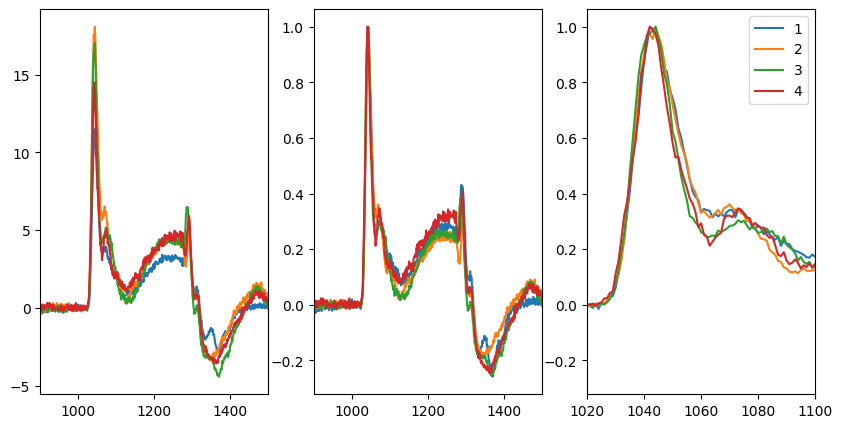

In [44]:
day_responses = np.array(day_responses)
day_baseline_sub = [d-np.mean(d[1000:1010]) for d in day_responses]
day_normed = [d/max(d) for d in day_baseline_sub]
fig, ax = plt.subplots(1, 3)
fig.set_size_inches([10, 5])
ax[0].plot(np.array(day_baseline_sub).T)
ax[0].set_xlim([900, 1500])
ax[1].plot(np.array(day_normed).T)
ax[1].set_xlim([900, 1500])

ax[2].plot(np.array(day_normed).T)
ax[2].set_xlim([1020, 1100])

ax[2].legend(['1', '2', '3', '4'])
# fig.savefig(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures', 
#                          'v1_im115_psth_normed_across_stimdays.pdf'))